In [1]:
import warnings
import pandas
import datetime, pytz
from persiantools.jdatetime import JalaliDate
from persiantools.jdatetime import JalaliDateTime
import jalali
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
data=pd.read_excel(r'C:\Users\asus\Desktop\New Proje\Feeder.xlsx','Sheet1')
data.head()

,date,A,B,C,D,E,F,G,H,J,K,L,Unnamed: 12,نظام مافي,A.1
0,1393/01/01,0,0,0,0,0,0,0,0,0,0,0,2014/3/21,پريا,B
1,1393/01/02,1,0,0,0,0,0,0,0,0,0,0,2014/3/22,جان محمدي,C
2,1393/01/03,1,0,0,0,0,0,0,0,0,0,0,2014/3/23,دهكده,D
3,1393/01/04,0,0,0,0,0,0,0,0,0,0,0,2014/3/24,سنگان,E
4,1393/01/05,0,0,0,0,0,0,0,0,0,0,0,2014/3/25,گذرنامه,F


In [3]:
datecols = ['date']
data[datecols] = data[datecols].applymap(lambda x: 
                                     JalaliDateTime(int(x[:4]),
                                                    int(x[5:7]),
                                                    int(x[8:10]),
                                                    
                                                    ).to_gregorian() if isinstance(x,str) else None)

In [4]:
df0=data[['date','A']]
df0 = df0.sort_values('date')

In [5]:
df0 = df0.groupby('date')['A'].sum().reset_index()

In [6]:
df0 = df0.set_index('date')
df0.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [7]:
y = df0['A']

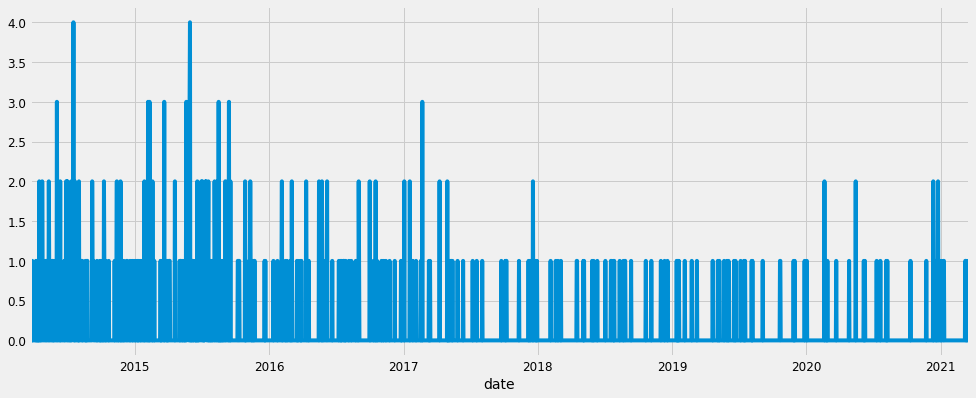

In [8]:
y.plot(figsize=(15, 6))
plt.show()

In [9]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [10]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0657      0.015      4.376      0.000       0.036       0.095
ma.L1         -1.0000      1.643     -0.609      0.543      -4.220       2.220
ar.S.L12      -0.5099      0.010    -53.131      0.000      -0.529      -0.491
sigma2         0.2912      0.479      0.608      0.543      -0.647       1.229


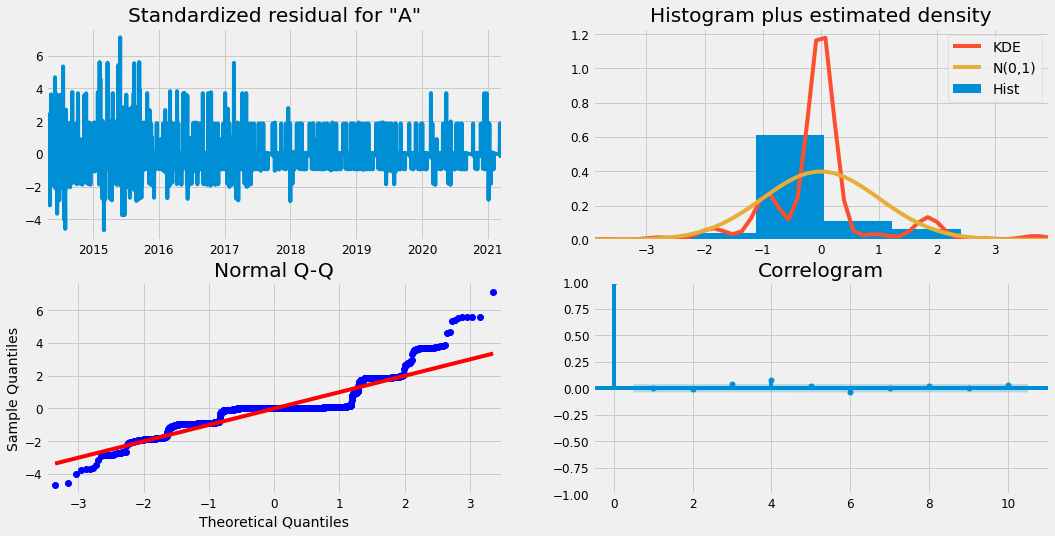

In [11]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

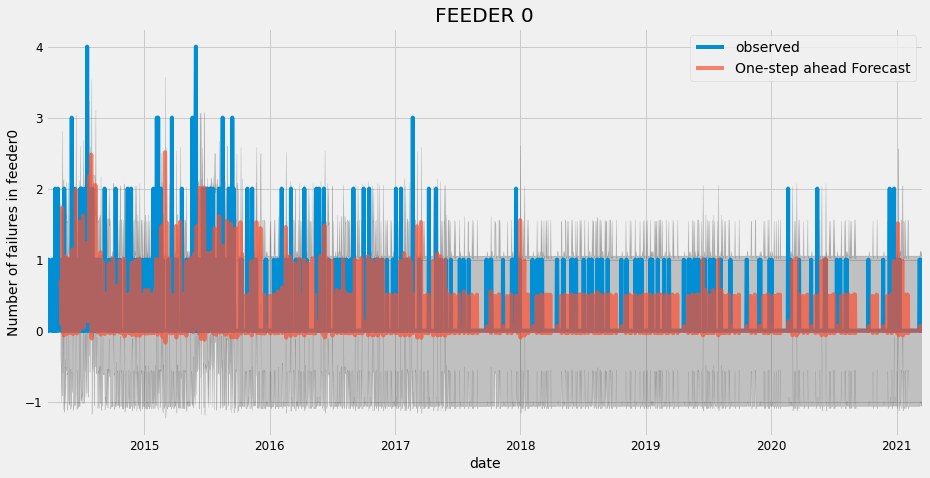

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2014-05-1'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
p=pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 0')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder0')
plt.legend()
plt.show()

In [26]:
df = pandas.DataFrame(pred.predicted_mean)
df['observed']=y
df['predicted_mean']=round(df['predicted_mean'])
df

,predicted_mean,observed
2014-05-01,1.0,0
2014-05-02,1.0,0
2014-05-03,0.0,0
2014-05-04,1.0,1
2014-05-05,0.0,1
...,...,...
2021-03-16,-0.0,0
2021-03-17,-0.0,0
2021-03-18,-0.0,0
2021-03-19,-0.0,0


### MAPE 

In [27]:
def mape(y_actual,y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape


In [28]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-03-09 10:46:00':]
mape1 = mape(y_truth,y_forecasted)
print('MAPE: {}'.format(round(mape1, 2)))

MAPE: inf


__MSE__

In [30]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-05-01 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: {}'.format(round(mse, 2)))

MSE: 0.29


__RMSE__

In [31]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 0.54


# Feeder1

In [19]:
df1=data[['date','B']]
df1 = df1.sort_values('date')

In [20]:
df1 = df1.groupby('date')['B'].sum().reset_index()

In [21]:
df1 = df1.set_index('date')
df1.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [23]:
y = df1['B']

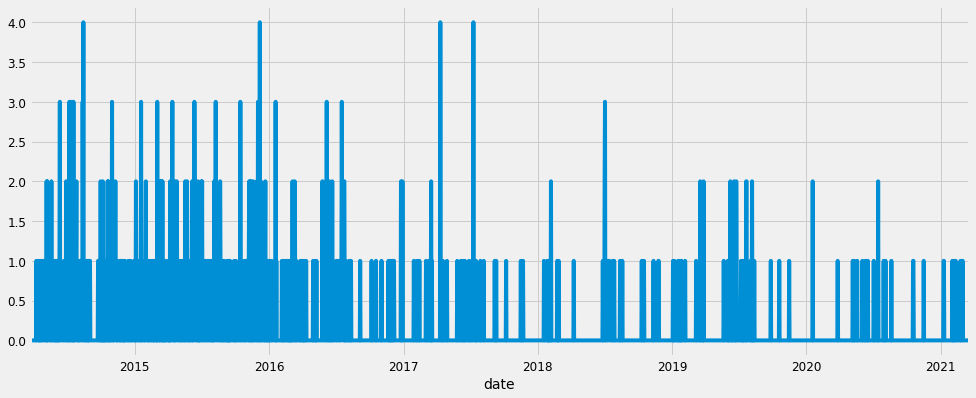

In [24]:
y.plot(figsize=(15, 6))
plt.show()

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0338      0.014      2.374      0.018       0.006       0.062
ma.L1         -1.0000      1.430     -0.699      0.484      -3.802       1.802
ar.S.L12      -0.4520      0.010    -44.930      0.000      -0.472      -0.432
sigma2         0.3678      0.525      0.700      0.484      -0.661       1.397


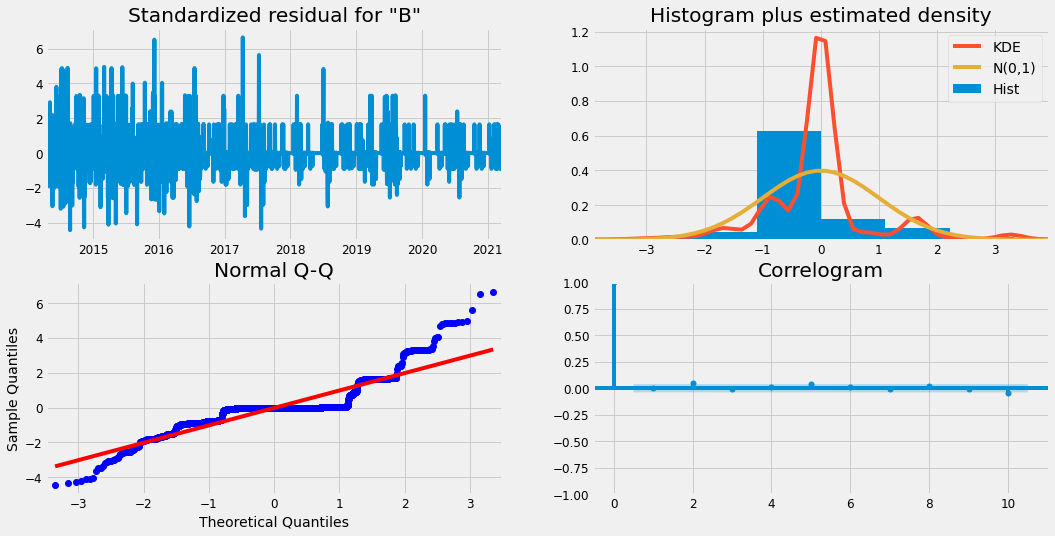

In [27]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

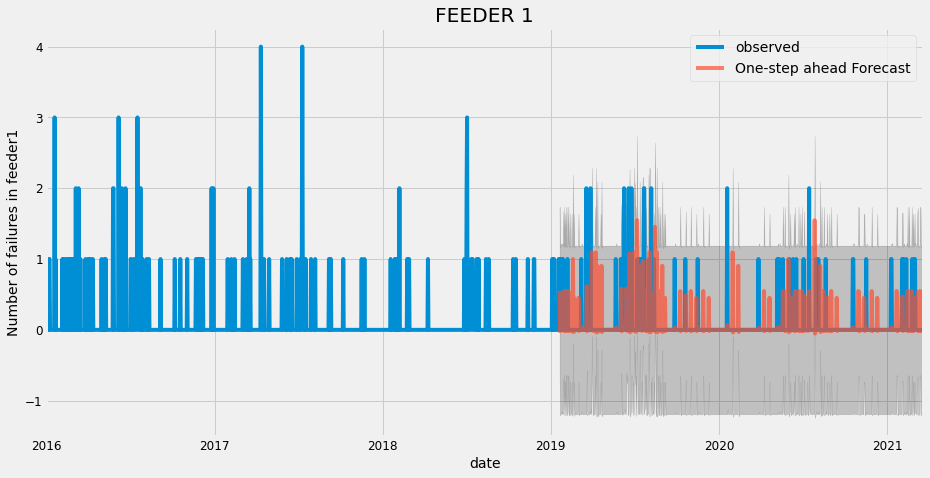

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 1')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder1')
plt.legend()
plt.show()

In [30]:
df = pandas.DataFrame(pred.predicted_mean)
df['observed']=y
df['predicted_mean']=round(df['predicted_mean'])
df

,predicted_mean,observed
2019-01-20,1.0,0
2019-01-21,-0.0,0
2019-01-22,0.0,1
2019-01-23,0.0,0
2019-01-24,0.0,0
...,...,...
2021-03-16,0.0,0
2021-03-17,0.0,0
2021-03-18,0.0,0
2021-03-19,0.0,0


__MSE__

In [31]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.15


__RMSE__

In [32]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.38


# Feeder2

In [33]:
df2=data[['date','C']]
df2 = df2.sort_values('date')

In [34]:
df2 = df2.groupby('date')['C'].sum().reset_index()

In [35]:
df2 = df2.set_index('date')
df2.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [36]:
y = df2['C']

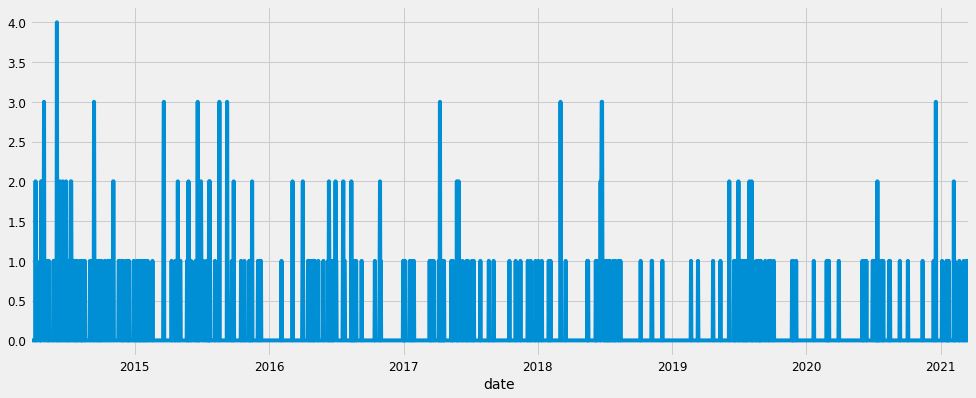

In [37]:
y.plot(figsize=(15, 6))
plt.show()

In [38]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [39]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0834      0.013      6.217      0.000       0.057       0.110
ma.L1         -1.0000      1.061     -0.942      0.346      -3.080       1.080
ar.S.L12      -0.5188      0.008    -61.389      0.000      -0.535      -0.502
sigma2         0.2513      0.267      0.941      0.347      -0.272       0.774


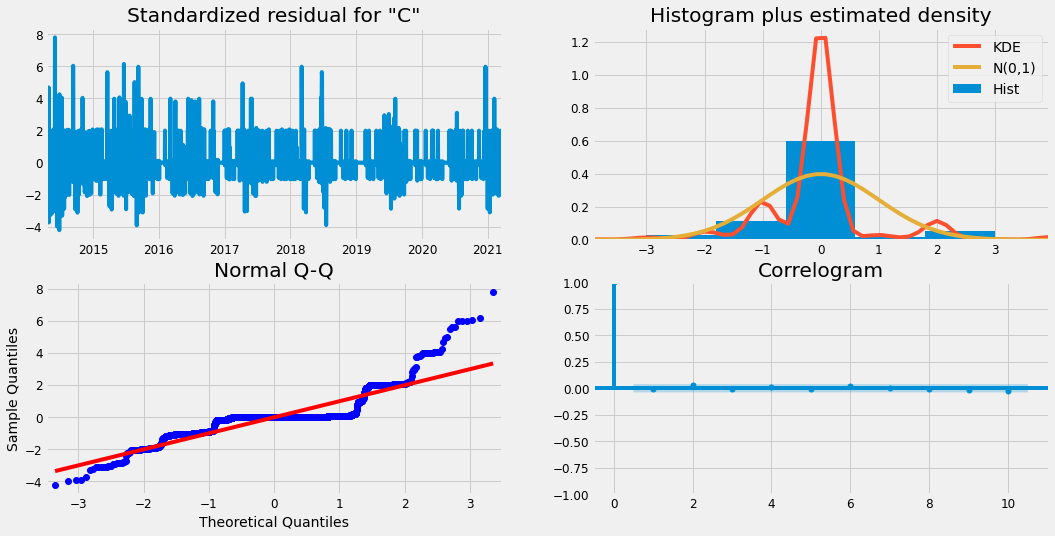

In [40]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

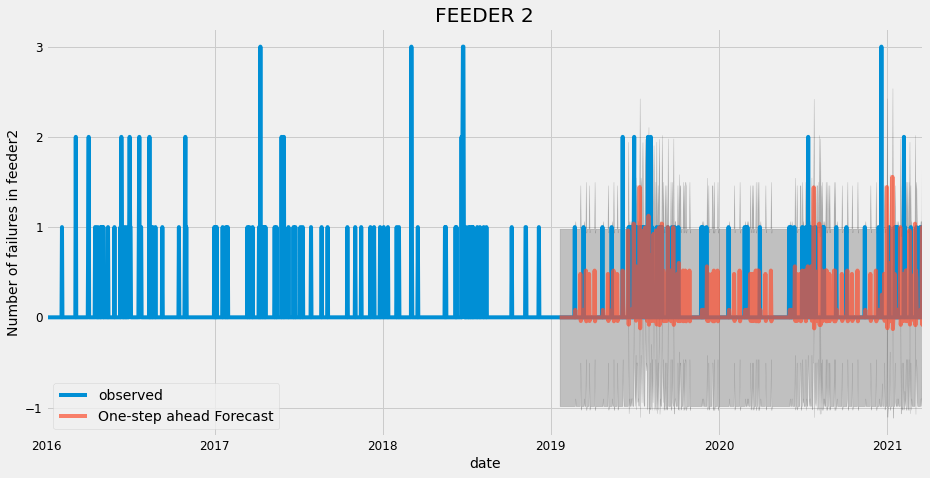

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 2')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder2')
plt.legend()
plt.show()

__MSE__

In [42]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.16


__RMSE__

In [43]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.4


# Feeder3


In [44]:
df3=data[['date','D']]
df3 = df3.sort_values('date')

In [45]:
df3 = df3.groupby('date')['D'].sum().reset_index()

In [46]:
df3 = df3.set_index('date')
df3.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [48]:
y = df3['D']

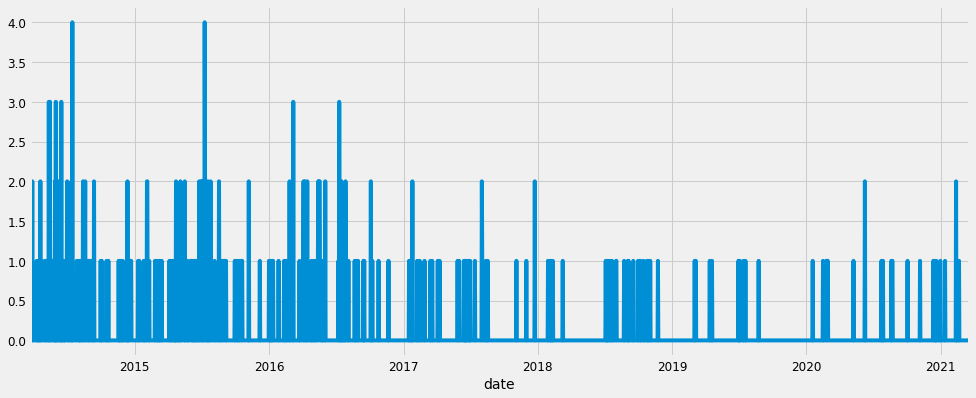

In [49]:
y.plot(figsize=(15, 6))
plt.show()

In [50]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [51]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0156      0.013      1.167      0.243      -0.011       0.042
ma.L1         -1.0000      1.686     -0.593      0.553      -4.305       2.305
ar.S.L12      -0.4650      0.009    -52.453      0.000      -0.482      -0.448
sigma2         0.2337      0.394      0.593      0.553      -0.539       1.006


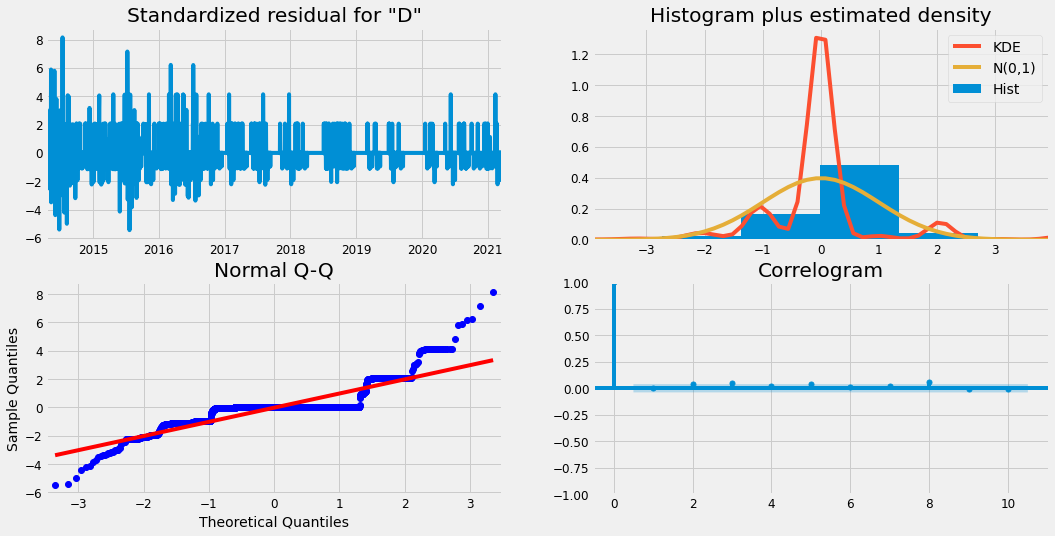

In [52]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

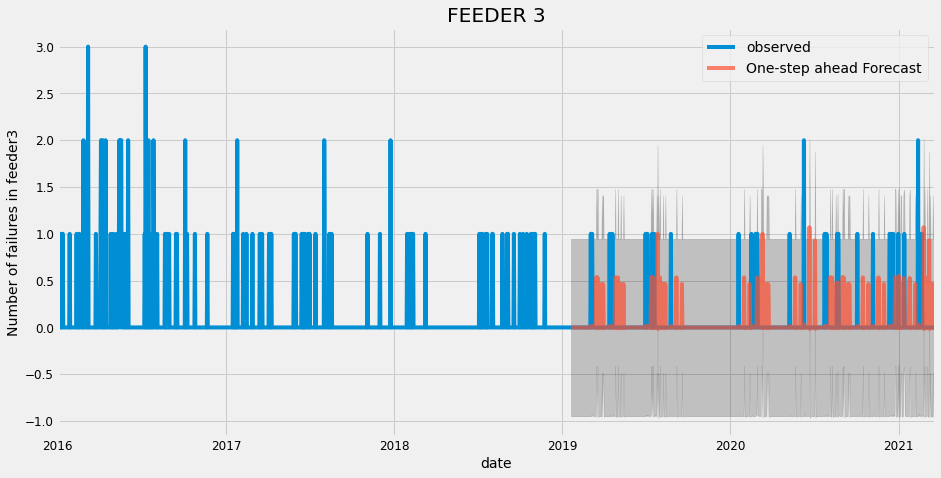

In [53]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 3')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder3')
plt.legend()
plt.show()

__MSE__

In [54]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.08


__RMSE__

In [55]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.27


# Feeder4

In [32]:
df4=data[['date','E']]
df4 = df4.sort_values('date')

In [33]:
df4 = df4.groupby('date')['E'].sum().reset_index()

In [34]:
df4 = df4.set_index('date')
df4.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [35]:
y = df4['E']

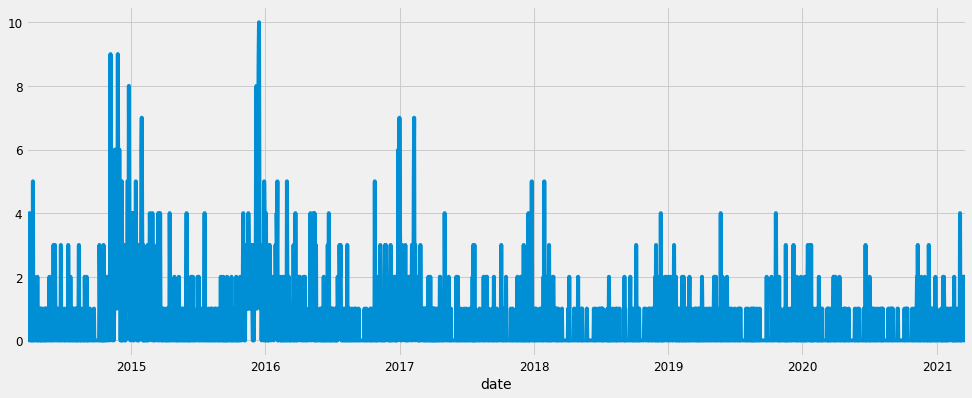

In [36]:
y.plot(figsize=(15, 6))
plt.show()

In [37]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [38]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2436      0.012     20.310      0.000       0.220       0.267
ma.L1         -1.0000      0.863     -1.158      0.247      -2.692       0.692
ar.S.L12      -0.4800      0.010    -46.719      0.000      -0.500      -0.460
sigma2         1.3699      1.186      1.155      0.248      -0.954       3.694


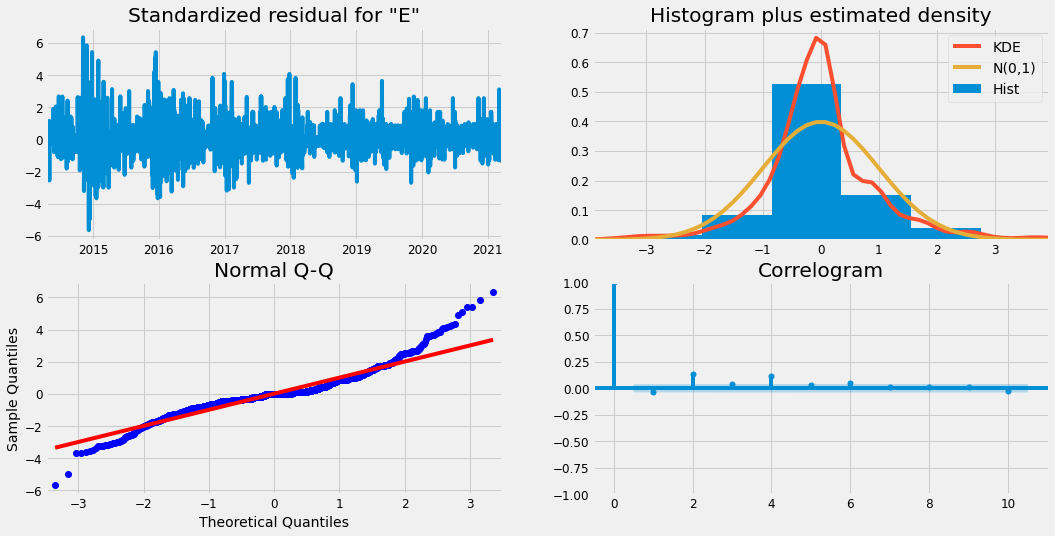

In [39]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

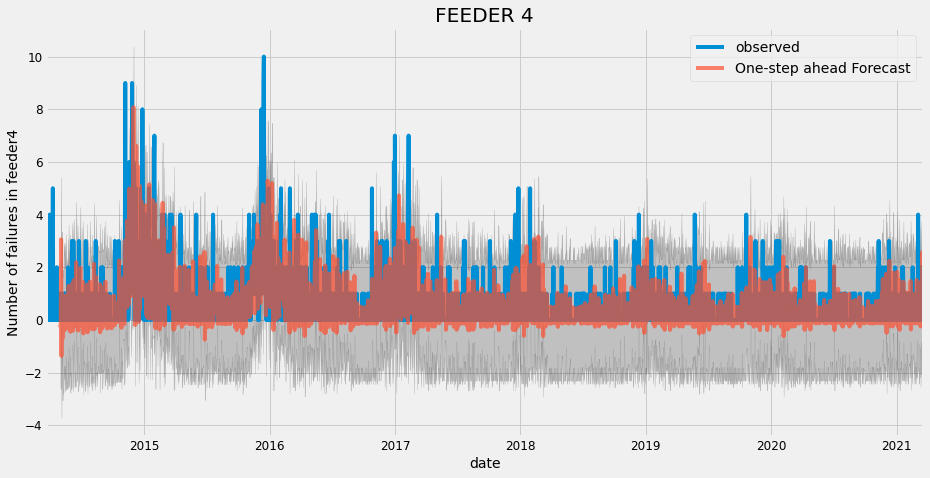

In [49]:
pred = results.get_prediction(start=pd.to_datetime('2014-05-1'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 4')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder4')
plt.legend()
plt.show()

__MSE__

In [50]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-05-01 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.37


__RMSE__

In [55]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1.19


In [53]:
df = pandas.DataFrame(pred.predicted_mean)
df['observed']=y
df['predicted_mean']=round(df['predicted_mean'])
df[df<0] = 0

df

,predicted_mean,observed
2014-05-01,-0.0,1
2014-05-02,-0.0,0
2014-05-03,3.0,0
2014-05-04,0.0,0
2014-05-05,1.0,1
...,...,...
2021-03-16,-0.0,2
2021-03-17,3.0,1
2021-03-18,0.0,2
2021-03-19,1.0,0


In [54]:
y_forecasted = df['predicted_mean']
y_truth = df['observed']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.41


In [57]:
df.to_csv(r'C:\Users\asus\Desktop\Numberpred.csv')

# Feeder5

In [68]:
df5=data[['date','F']]
df5 = df5.sort_values('date')

In [69]:
df5 = df5.groupby('date')['F'].sum().reset_index()

In [70]:
df5 = df5.set_index('date')
df5.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [72]:
y = df5['F']

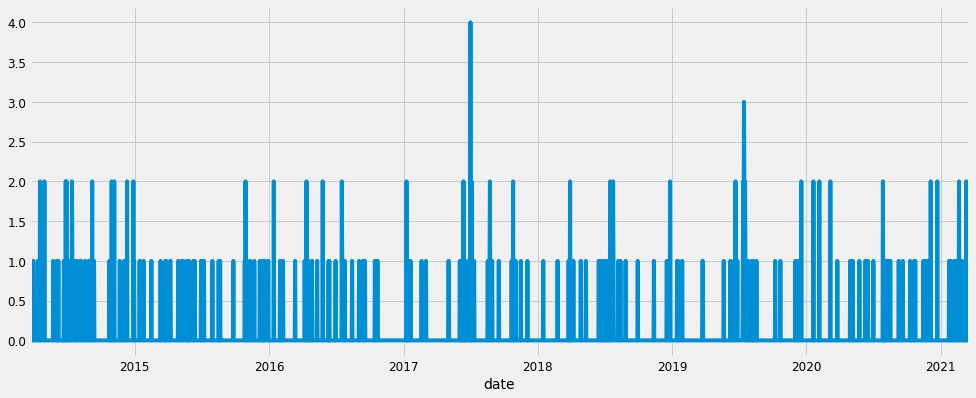

In [73]:
y.plot(figsize=(15, 6))
plt.show()

In [74]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [75]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0627      0.020      3.116      0.002       0.023       0.102
ma.L1         -1.0000      0.642     -1.557      0.119      -2.259       0.259
ar.S.L12      -0.5132      0.008    -62.077      0.000      -0.529      -0.497
sigma2         0.1825      0.118      1.549      0.121      -0.048       0.413


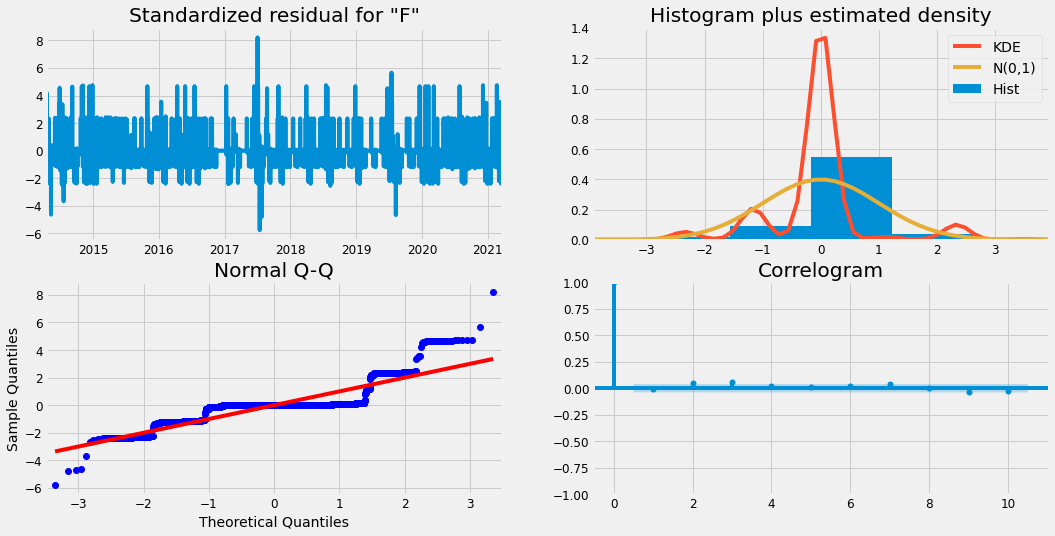

In [76]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

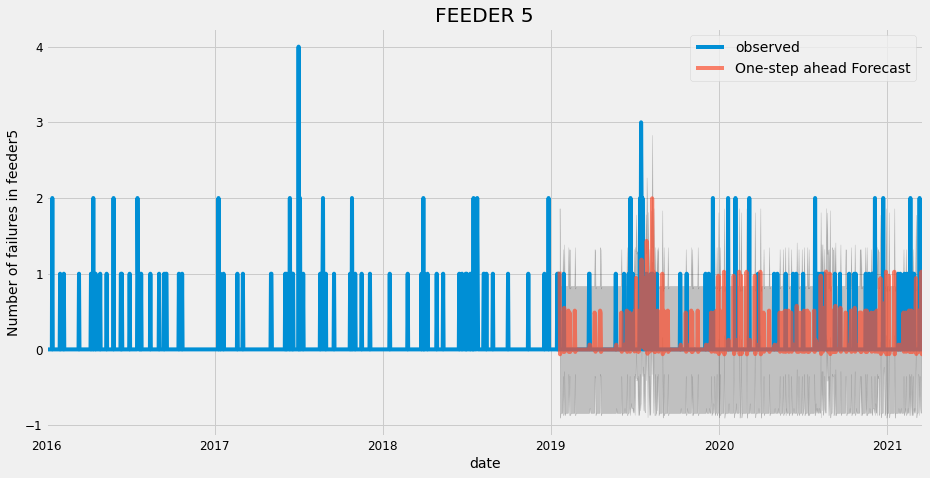

In [77]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20 '), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 5')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder5')
plt.legend()
plt.show()

__MSE__

In [78]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.19


__RMSE__

In [79]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.43


# Feeder6

In [80]:
df6=data[['date','G']]
df6 = df6.sort_values('date')

In [81]:
df6 = df6.groupby('date')['G'].sum().reset_index()

In [82]:
df6 = df6.set_index('date')
df6.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [84]:
y = df6['G']

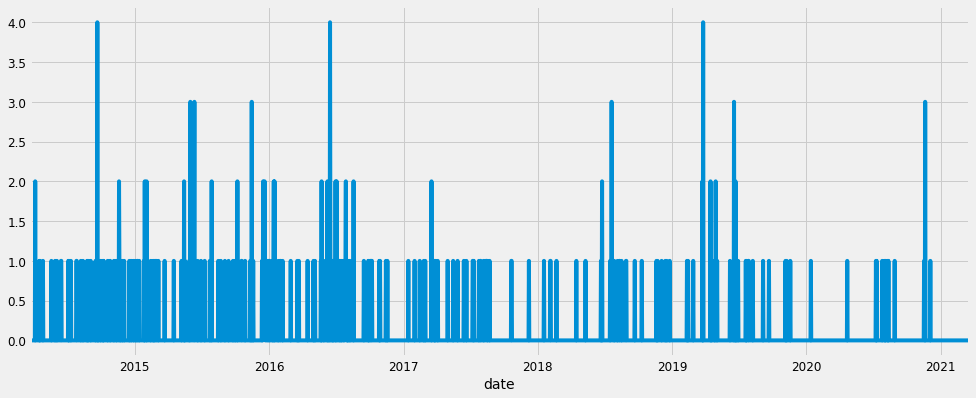

In [85]:
y.plot(figsize=(15, 6))
plt.show()

In [86]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [87]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0288      0.017      1.736      0.083      -0.004       0.061
ma.L1         -1.0000      1.346     -0.743      0.457      -3.637       1.637
ar.S.L12      -0.5197      0.007    -72.169      0.000      -0.534      -0.506
sigma2         0.2067      0.279      0.742      0.458      -0.340       0.753


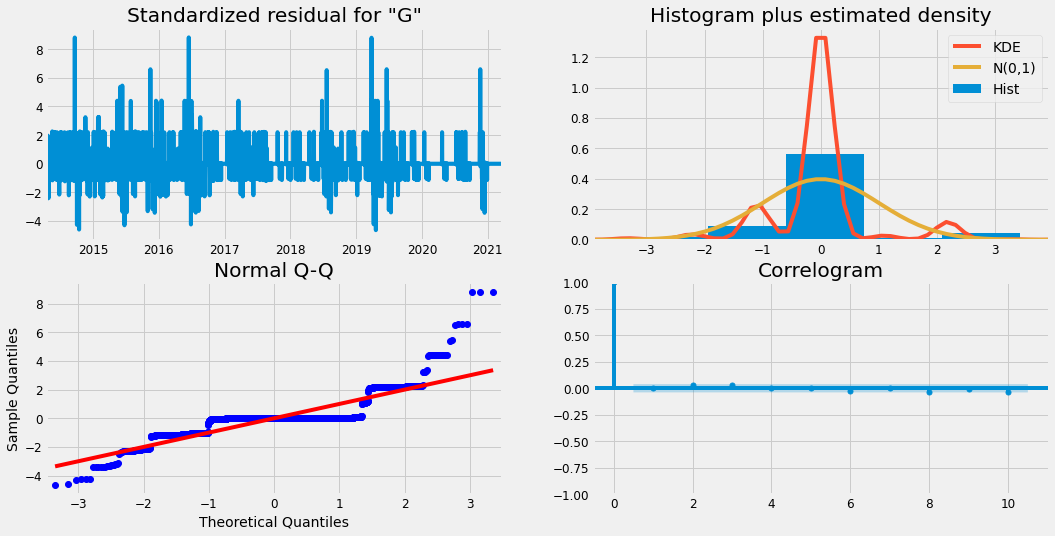

In [88]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

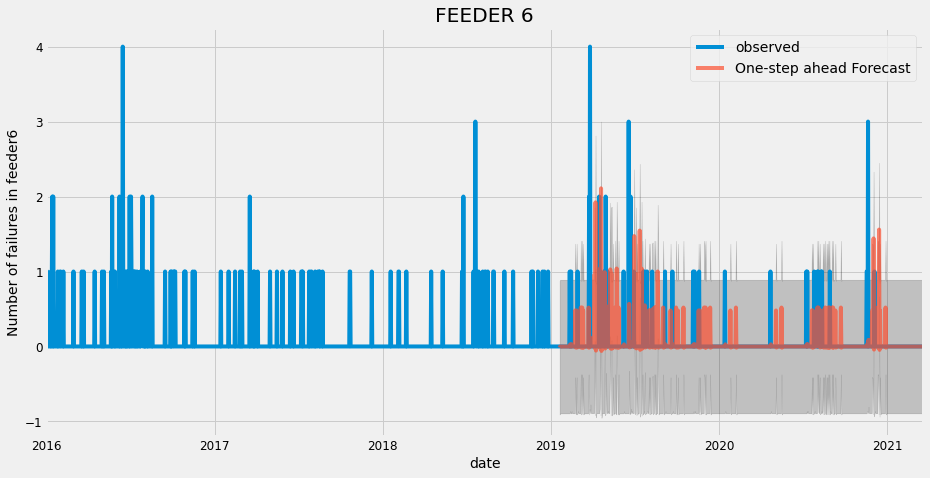

In [89]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 6')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder6')
plt.legend()
plt.show()

__MSE__

In [90]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.15


__RMSE__

In [91]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.39


# Feeder7


In [92]:
df7=data[['date','H']]
df7 = df7.sort_values('date')

In [93]:
df7 = df7.groupby('date')['H'].sum().reset_index()

In [94]:
df7 = df7.set_index('date')
df7.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [96]:
y = df7['H']

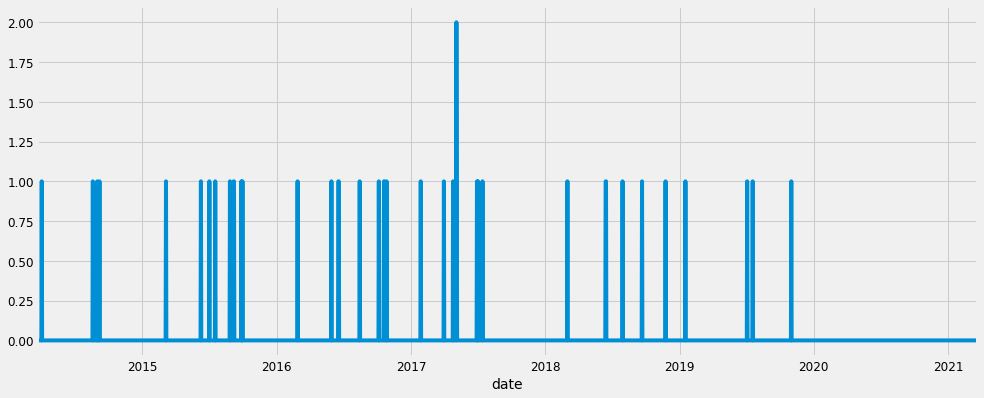

In [97]:
y.plot(figsize=(15, 6))
plt.show()

In [98]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [99]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1204      0.009     12.880      0.000       0.102       0.139
ma.L1         -1.0000      0.489     -2.046      0.041      -1.958      -0.042
ar.S.L12      -0.4804      0.005    -97.447      0.000      -0.490      -0.471
sigma2         0.0239      0.012      2.031      0.042       0.001       0.047


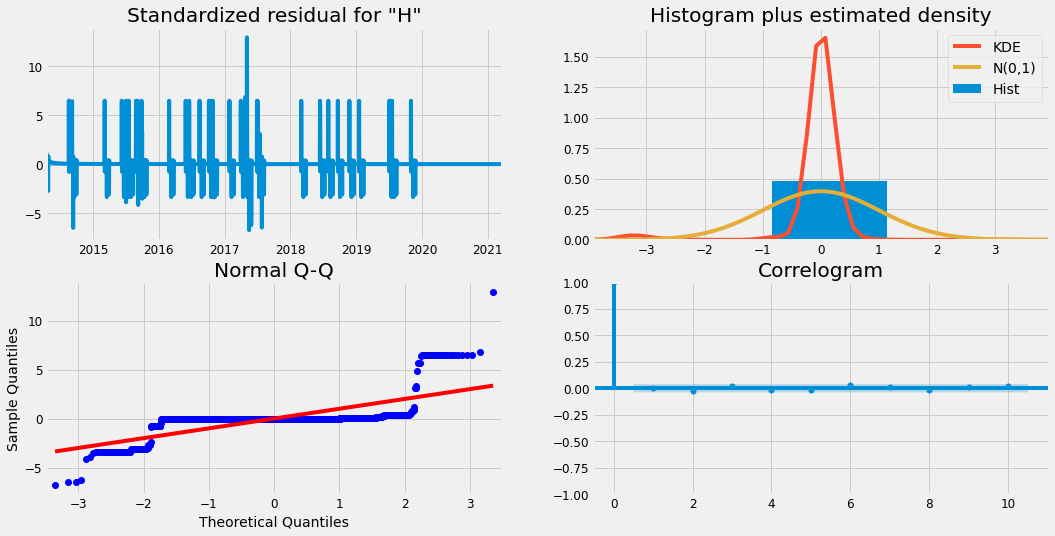

In [100]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

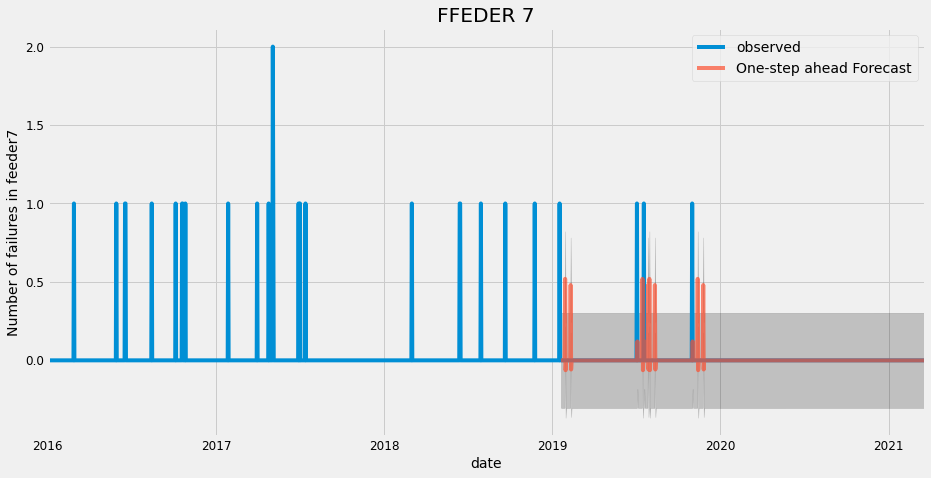

In [101]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FFEDER 7')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder7')
plt.legend()
plt.show()

__MSE__

In [102]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


__RMSE__

In [103]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.08


# Feeder8

In [104]:
df8=data[['date','J']]
df8 = df8.sort_values('date')

In [105]:
df8 = df8.groupby('date')['J'].sum().reset_index()

In [106]:
df8 = df8.set_index('date')
df8.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [108]:
y = df8['J']

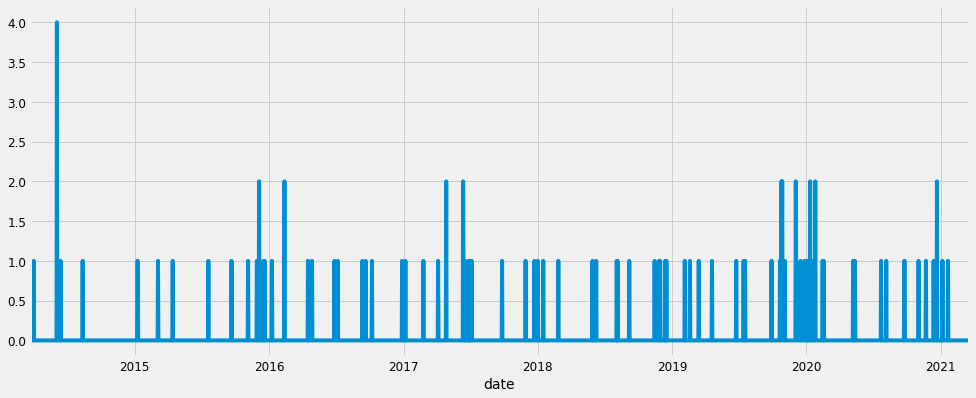

In [109]:
y.plot(figsize=(15, 6))
plt.show()

In [110]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [111]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0524      0.016      3.238      0.001       0.021       0.084
ma.L1         -1.0000      0.672     -1.488      0.137      -2.318       0.318
ar.S.L12      -0.5093      0.005   -106.267      0.000      -0.519      -0.500
sigma2         0.0734      0.049      1.484      0.138      -0.024       0.170


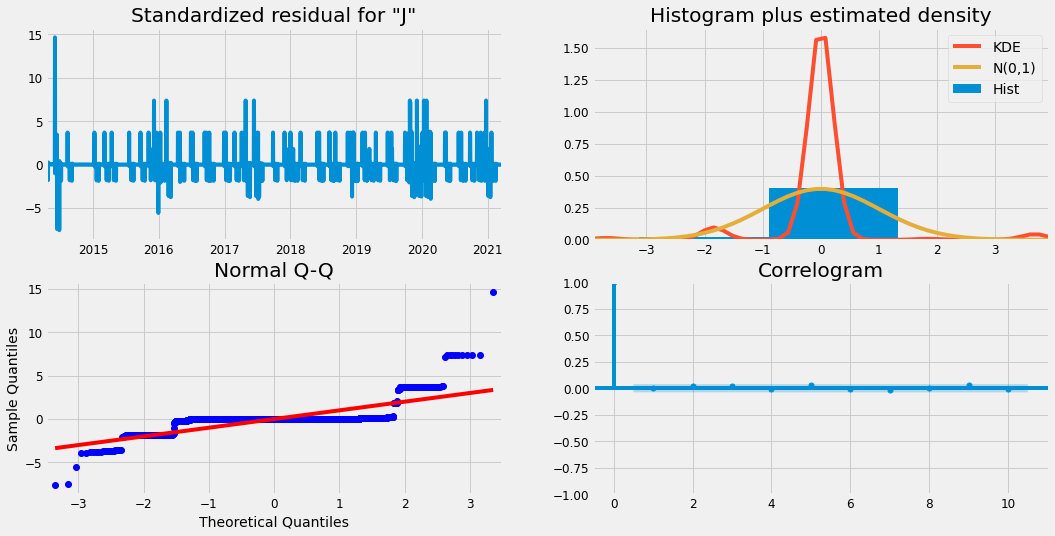

In [112]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

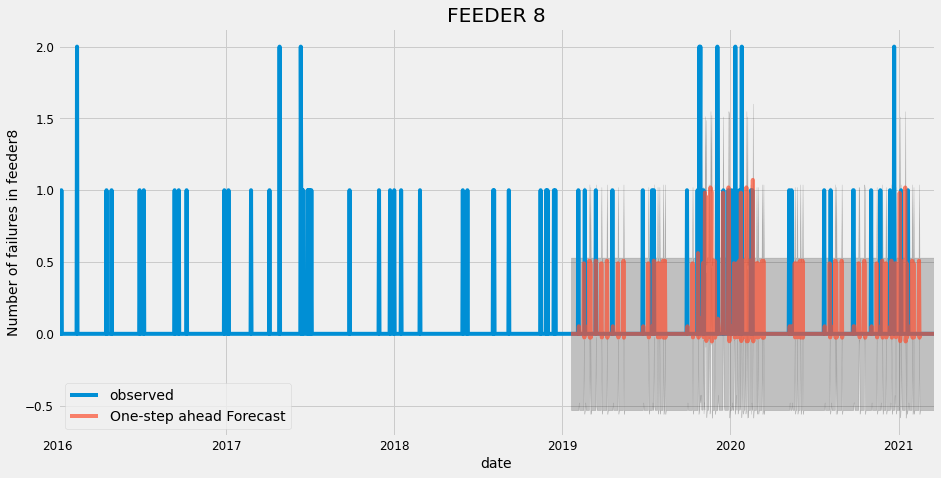

In [113]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 8')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder8')
plt.legend()
plt.show()

__MSE__

In [114]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.09


__RMSE__

In [115]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.3


# Feeder9

In [116]:
df9=data[['date','K']]
df9 = df9.sort_values('date')

In [117]:
df9 = df9.groupby('date')['K'].sum().reset_index()

In [118]:
df9 = df9.set_index('date')
df9.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [120]:
y = df9['K']

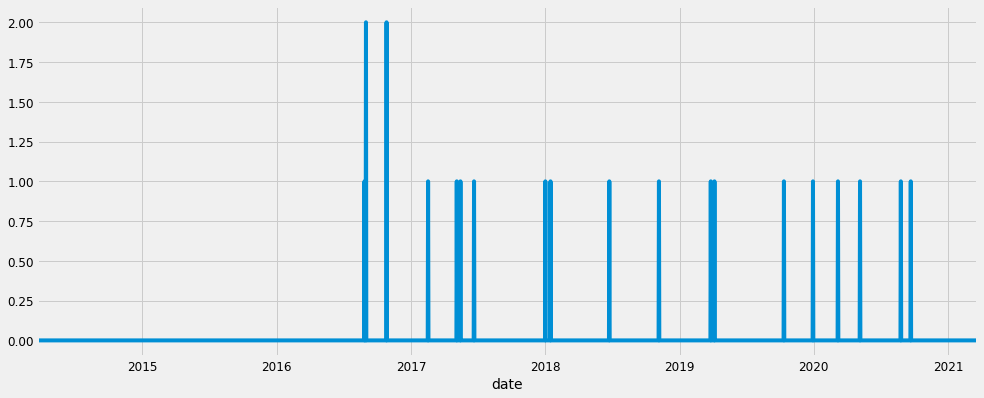

In [121]:
y.plot(figsize=(15, 6))
plt.show()

In [122]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [123]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002      1.335      0.000      1.000      -2.616       2.616
ma.L1         -1.0000      0.977     -1.024      0.306      -2.915       0.915
ar.S.L12      -0.5000      0.003   -156.780      0.000      -0.506      -0.494
sigma2         0.0148      0.015      1.021      0.307      -0.014       0.043


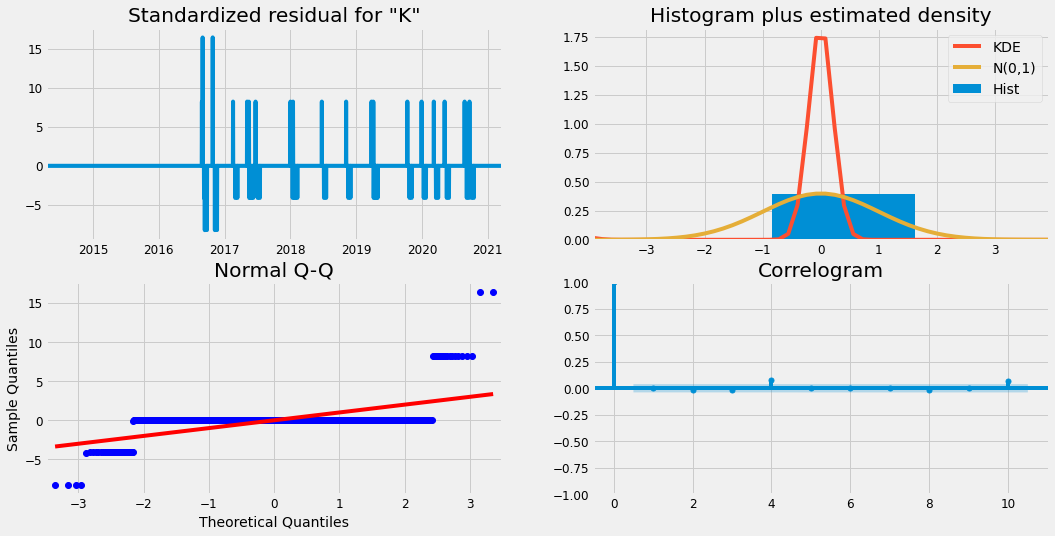

In [124]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

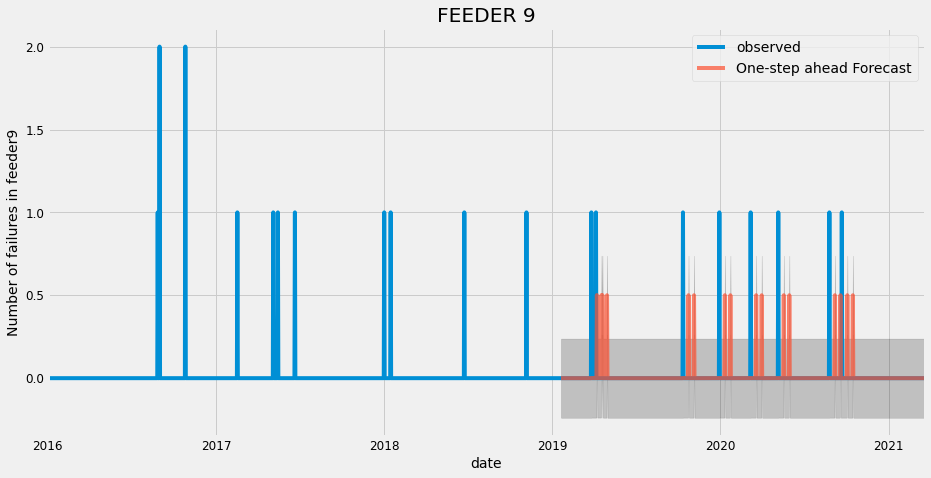

In [125]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 9')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder9')
plt.legend()
plt.show()

__MSE__

In [126]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.02


__RMSE__

In [127]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.12


# Feeder10

In [128]:
df10=data[['date','L']]
df10 = df10.sort_values('date')

In [129]:
df10 = df10.groupby('date')['L'].sum().reset_index()

In [130]:
df10 = df10.set_index('date')
df10.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [132]:
y = df10['L']

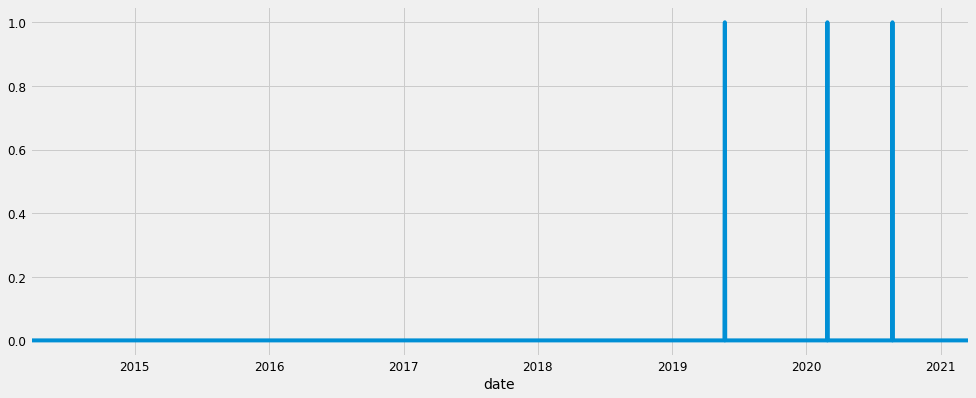

In [133]:
y.plot(figsize=(15, 6))
plt.show()

In [134]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [135]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002      1.460      0.000      1.000      -2.862       2.862
ma.L1         -1.0000      0.307     -3.254      0.001      -1.602      -0.398
ar.S.L12      -0.5000      0.002   -321.618      0.000      -0.503      -0.497
sigma2         0.0018      0.001      3.238      0.001       0.001       0.003


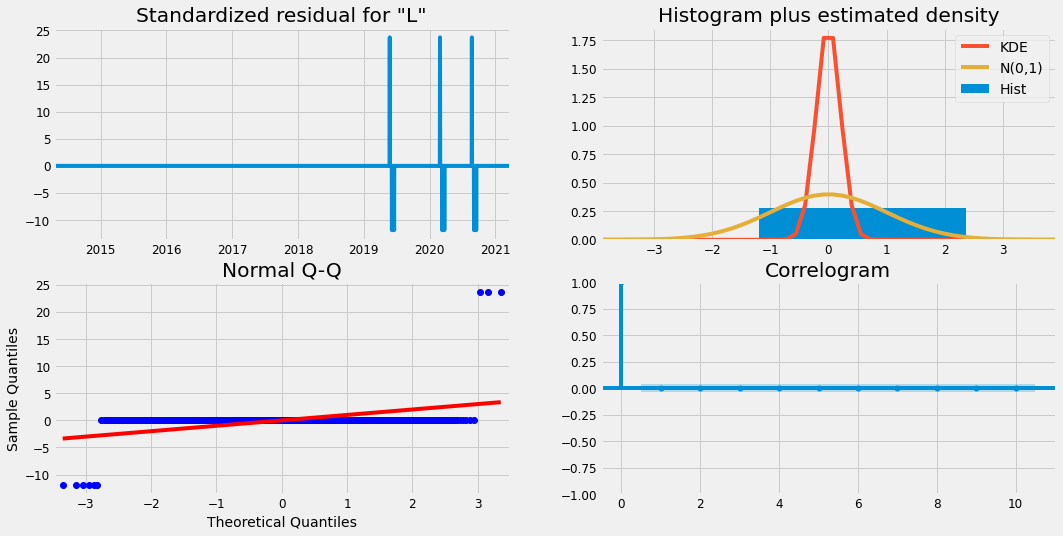

In [136]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

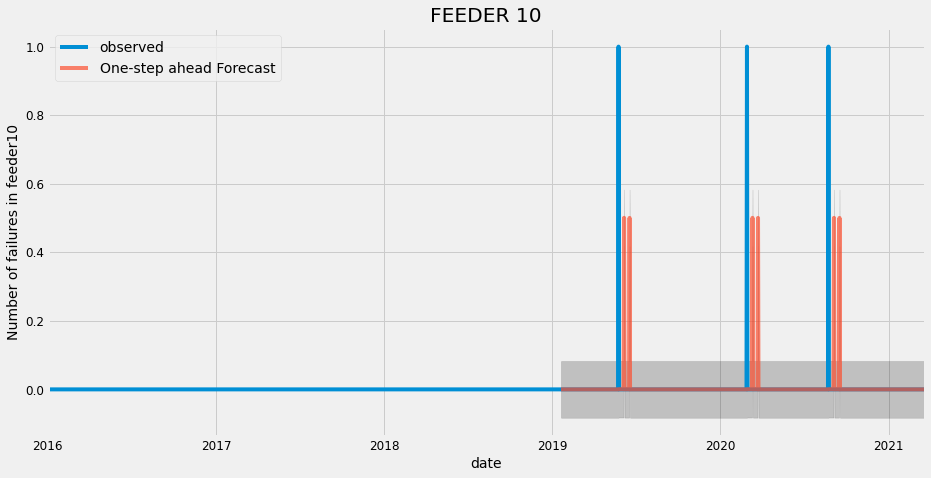

In [137]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 10')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder10')
plt.legend()
plt.show()

__MSE__

In [138]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


__RMSE__

In [139]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.08


# Feeder11

In [127]:
df11=data[['date','feeder11']]
df11 = df11.sort_values('date')

In [128]:
df11 = df11.groupby('date')['feeder11'].sum().reset_index()

In [129]:
df11 = df11.set_index('date')
df11.index

DatetimeIndex(['2016-03-20 22:33:00', '2016-03-21 19:22:00',
               '2016-03-22 19:21:00', '2016-03-23 18:25:00',
               '2016-03-24 18:20:00', '2016-03-25 18:14:00',
               '2016-03-26 16:46:00', '2016-03-27 13:44:00',
               '2016-03-28 10:14:00', '2016-03-29 06:31:00',
               ...
               '2019-03-11 22:16:00', '2019-03-12 18:43:00',
               '2019-03-13 18:29:00', '2019-03-14 17:36:00',
               '2019-03-15 16:35:00', '2019-03-16 12:18:00',
               '2019-03-17 11:53:00', '2019-03-18 11:37:00',
               '2019-03-19 11:03:00', '2019-03-20 10:41:00'],
              dtype='datetime64[ns]', name='date', length=1095, freq=None)

In [130]:
y = df11['feeder11']

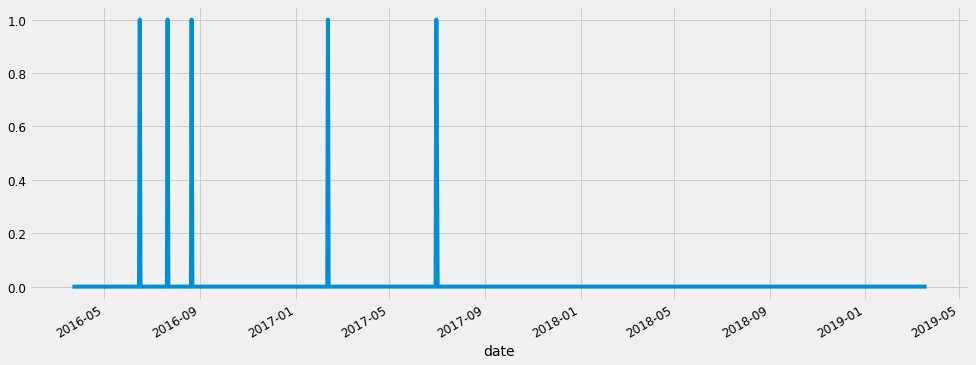

In [131]:
y.plot(figsize=(15, 6))
plt.show()

In [132]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [133]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0005      0.298      0.002      0.999      -0.583       0.584
ma.L1         -1.0000      8.868     -0.113      0.910     -18.381      16.381
ar.S.L12      -0.5000      0.005   -101.362      0.000      -0.510      -0.490
sigma2         0.0070      0.062      0.113      0.910      -0.115       0.129


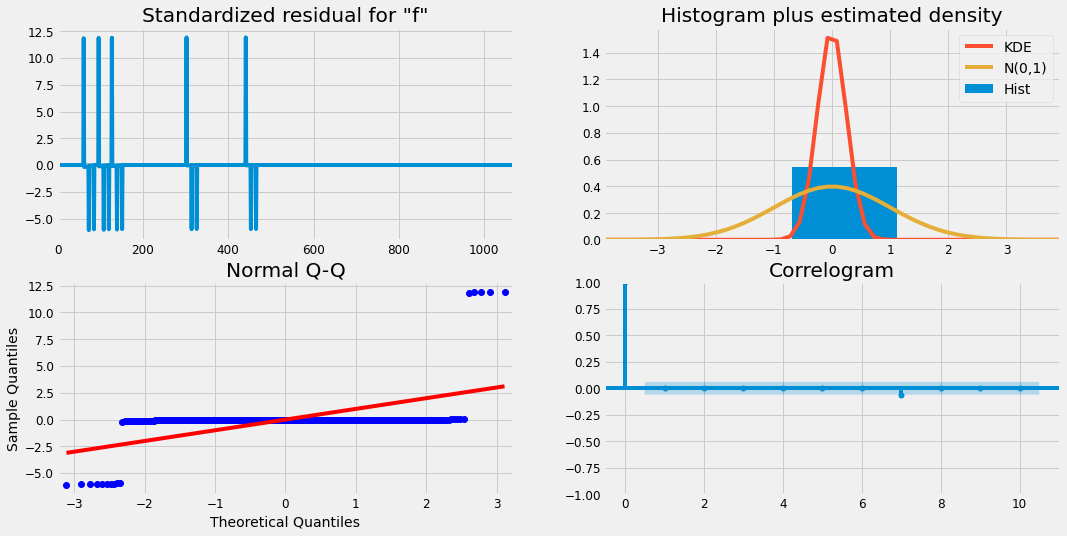

In [134]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

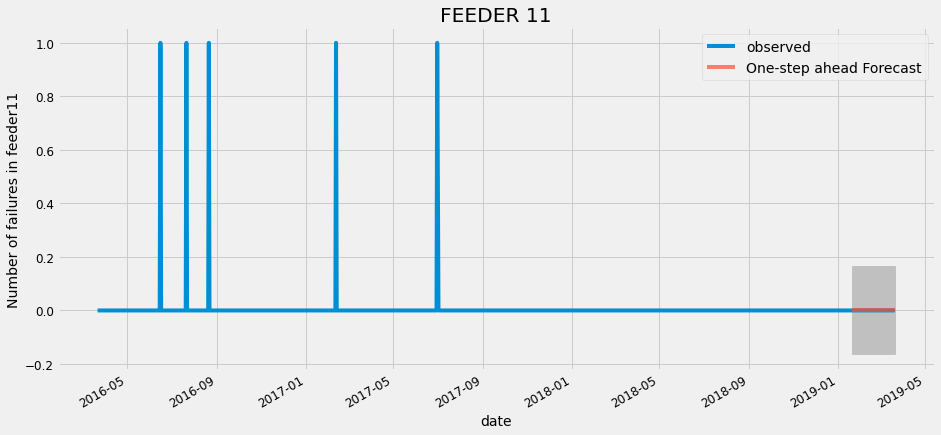

In [137]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20 09:53:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 11')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder11')
plt.legend()
plt.show()

__MSE__

In [323]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


__RMSE__

In [324]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 0.0


# Feeder12

In [138]:
df12=data[['date','feeder12']]
df12 = df12.sort_values('date')

In [139]:
df12 = df12.groupby('date')['feeder12'].sum().reset_index()

In [140]:
df12 = df12.set_index('date')
df12.index

DatetimeIndex(['2016-03-20 22:33:00', '2016-03-21 19:22:00',
               '2016-03-22 19:21:00', '2016-03-23 18:25:00',
               '2016-03-24 18:20:00', '2016-03-25 18:14:00',
               '2016-03-26 16:46:00', '2016-03-27 13:44:00',
               '2016-03-28 10:14:00', '2016-03-29 06:31:00',
               ...
               '2019-03-11 22:16:00', '2019-03-12 18:43:00',
               '2019-03-13 18:29:00', '2019-03-14 17:36:00',
               '2019-03-15 16:35:00', '2019-03-16 12:18:00',
               '2019-03-17 11:53:00', '2019-03-18 11:37:00',
               '2019-03-19 11:03:00', '2019-03-20 10:41:00'],
              dtype='datetime64[ns]', name='date', length=1095, freq=None)

In [141]:
y = df12['feeder12']

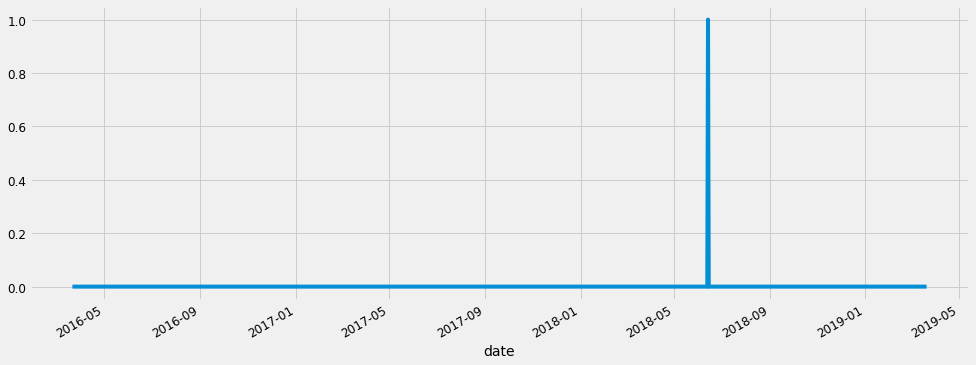

In [142]:
y.plot(figsize=(15, 6))
plt.show()

In [143]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0004      0.804      0.001      1.000      -1.576       1.577
ma.L1         -1.0000      1.020     -0.981      0.327      -2.999       0.999
ar.S.L12      -0.5000      0.002   -234.553      0.000      -0.504      -0.496
sigma2         0.0014      0.001      0.979      0.328      -0.001       0.004


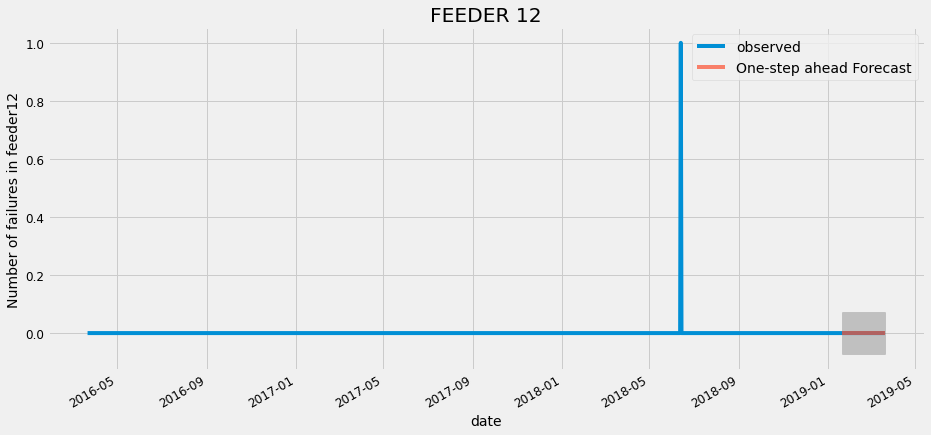

In [145]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-20 09:53:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('FEEDER 12')
ax.set_xlabel('date')
ax.set_ylabel('Number of failures in feeder12')
plt.legend()
plt.show()

__MSE__

In [146]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


# Feeder13

In [147]:
df13=data[['date','feeder13']]
df13 = df13.sort_values('date')

In [148]:
df13 = df13.groupby('date')['feeder13'].sum().reset_index()

In [149]:
df13 = df13.set_index('date')
df13.index

DatetimeIndex(['2016-03-20 22:33:00', '2016-03-21 19:22:00',
               '2016-03-22 19:21:00', '2016-03-23 18:25:00',
               '2016-03-24 18:20:00', '2016-03-25 18:14:00',
               '2016-03-26 16:46:00', '2016-03-27 13:44:00',
               '2016-03-28 10:14:00', '2016-03-29 06:31:00',
               ...
               '2019-03-11 22:16:00', '2019-03-12 18:43:00',
               '2019-03-13 18:29:00', '2019-03-14 17:36:00',
               '2019-03-15 16:35:00', '2019-03-16 12:18:00',
               '2019-03-17 11:53:00', '2019-03-18 11:37:00',
               '2019-03-19 11:03:00', '2019-03-20 10:41:00'],
              dtype='datetime64[ns]', name='date', length=1095, freq=None)

In [150]:
y = df13['feeder13']

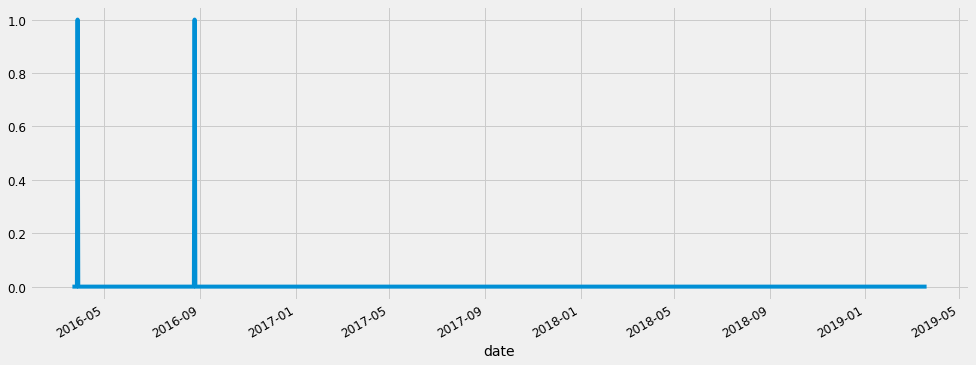

In [151]:
y.plot(figsize=(15, 6))
plt.show()